[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://drive.google.com/file/d/1kYjGK-X8u_C0vR7T5M1xyMYVgLVjDYc1/view?usp=sharing)

In [1]:
import tensorflow as tf
from collections import Counter
from sklearn.model_selection import train_test_split
import pickle
import os
import re
import itertools
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# Add dataset path
path = "./data/"
folder = "raw/"
filename = "Rest_Mex_Sentiment_Analysis_2023_Train.xlsx"
# reading the data
df = pd.read_excel(path + folder + filename)
df = df.fillna("")

In [3]:
def to_weights(x):
    return 1.0 / x


X, y = df["Review"], df["Polarity"]
df["Polarity"] = df["Polarity"] - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

datasets = pd.DataFrame({"X_train": X_train, "y_train": y_train})

test = pd.DataFrame({"X_test": X_test, "y_test": y_test})

print(f"Stratified sampling mode : ")
datasets["freq"] = datasets.groupby("y_train")["y_train"].transform("count")
test["freq"] = test.groupby("y_test")["y_test"].transform("count")
datasets_balanced = datasets.sample(
    n=len(datasets), replace=True, weights=datasets["freq"].apply(to_weights)
).copy()
test_balanced = test.sample(
    n=len(test), replace=True, weights=test["freq"].apply(to_weights)
).copy()

Stratified sampling mode : 


In [4]:
print(f"The values of the first 5 rows are : ")
datasets_balanced.head()

The values of the first 5 rows are : 


,X_train,y_train,freq
102408,Tengo casi 4 años viniendo a este hotel por qu...,2,4685
83697,todo esta bien en el hotel tienen una buena ...,4,40137
219747,Le descripción está errónea deberían de actual...,3,14557
25161,"pero no, es relativamente pequeño, lo recorres...",3,14557
184955,A juzgar por algunas de las otras críticas de ...,4,40137


### Sentiment Analysis (Polarity)

In [5]:
def preprocess(X_batch, min_length=0, max_length=308, tensor_mode=True):
    X_batch = str(X_batch).lower()
    X_batch = re.sub(r"[á']", r"a", X_batch)
    X_batch = re.sub(r"[é']", r"e", X_batch)
    X_batch = re.sub(r"[í']", r"i", X_batch)
    X_batch = re.sub(r"[ó']", r"o", X_batch)
    X_batch = re.sub(r"[ú']", r"u", X_batch)
    # X_batch = ''.join(i for i, _ in itertools.groupby(X_batch))
    X_batch = re.sub(r"(.)\1+", r"\1", X_batch)
    X_batch = tf.strings.substr(X_batch, min_length, max_length)
    X_batch = tf.strings.regex_replace(X_batch, r"[^a-zA-Zñ']", r" ")
    X_batch = tf.strings.regex_replace(X_batch, r"[^\w\s]", r"")
    X_batch = tf.strings.split(X_batch)
    X_batch = [str(w).replace("b'", "").replace("'", "") for w in X_batch.numpy()]
    if tensor_mode:
        n = len(X_batch)
        X_add = [""] * (max_length - n)
        X_batch += X_add
        return tf.convert_to_tensor(X_batch)
    else:
        return X_batch

In [6]:
if os.path.exists("vocab.pkl"):
    with open("vocab.pkl", "rb") as file:
        vocabulary = pickle.load(file)
else:
    vocabulary = Counter()
    reviews = datasets.iloc[:, 0].apply(preprocess, tensor_mode=False)
    for X_batch in reviews:
        vocabulary.update(X_batch)

    with open("vocab.pkl", "wb") as file:
        pickle.dump(vocabulary, file)

In [7]:
# top 5 most common words
vocabulary.most_common()[:5]

[('de', 442780), ('la', 366220), ('y', 352547), ('el', 283140), ('en', 238978)]

In [8]:
print(f"Total size of the vocabulary : ", "{:,}".format(len(vocabulary.most_common())))
print("-------------------------------------------------------")

Total size of the vocabulary :  90,323
-------------------------------------------------------


In [9]:
# let's truncate the vocabulary, keeping only the 10,000 most common words
vocab_size = 10000
truncated_vocabulary = [word for word, count in vocabulary.most_common()[:vocab_size]]

# now we add a preprocessing step to replace each work with its ID
words = tf.constant(truncated_vocabulary)
words_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, words_ids)
# we will create a lookup table for this, using 1,000 out-of-vocabulary (oov) buckets
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [10]:
print(f"1) Example of use.")
print("-------------------------------------------------------")
text = "Muy buena la atención de principio a fin en el restaurante Serratta. Por parte de Jonathan. Recomendado."
# print('preprocess text : ', preprocess(text))
# table.lookup(preprocess(text)).numpy()

1) Example of use.
-------------------------------------------------------


In [11]:
depth = 5


# now we create the encode_words() function that uses the table we just built
def encode_words(X_batch):
    if X_batch.isnumeric():
        X_batch = ""
    return list(table[preprocess(X_batch)].numpy())


datasets_balanced = datasets_balanced.drop(columns=["freq"])
test_balanced = test_balanced.drop(columns=["freq"])
training_sentences = datasets_balanced["X_train"].to_list()
testing_sentences = test_balanced["X_test"].to_list()

embed_size = 16
max_length = 32
trunc_type = "post"
padding_type = "post"
oov_tok = ""

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(training_sentences)

padded = tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type
)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = tf.keras.preprocessing.sequence.pad_sequences(
    testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type
)
padded.shape

(168640, 32)

In [12]:
if os.path.exists("train_x.pkl"):
    with open("train_x.pkl", "rb") as file:
        train_x = pickle.load(file)

    with open("test_x.pkl", "rb") as file:
        test_x = pickle.load(file)
else:
    train_x = np.array(
        [encode_words(sentence) for sentence in datasets_balanced["X_train"].to_list()]
    )
    test_x = np.array([encode_words(sentence) for sentence in test_balanced["X_test"].to_list()])

    with open("train_x.pkl", "wb") as file:
        pickle.dump(train_x, file)

    with open("test_x.pkl", "wb") as file:
        pickle.dump(test_x, file)

In [13]:
if os.path.exists("hub_train_x.pkl"):
    with open("hub_train_x.pkl", "rb") as file:
        hub_train_x = pickle.load(file)

    with open("hub_test_x.pkl", "rb") as file:
        hub_test_x = pickle.load(file)
else:
    hub_train_x = np.array([sentence for sentence in datasets_balanced["X_train"].to_list()])
    hub_test_x = np.array([sentence for sentence in test_balanced["X_test"].to_list()])

    with open("hub_train_x.pkl", "wb") as file:
        pickle.dump(hub_train_x, file)

    with open("hub_test_x.pkl", "wb") as file:
        pickle.dump(hub_test_x, file)

In [14]:
train_y = datasets_balanced["y_train"]
train_y = (tf.one_hot(train_y, depth)).numpy()

test_y = test_balanced["y_test"]
test_y = (tf.one_hot(test_y, depth)).numpy()

train_x.shape

(168640, 308)

In [15]:
train_y.shape

(168640, 5)

### Reusing Pretrained Embeddings

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/35
5270/5270 [==============================] - 43s 8ms/step - loss: 0.4253 - accuracy: 0.2007 - val_loss: 0.4065 - val_accuracy: 0.2001
Epoch 2/35
5270/5270 [==============================] - 33s 6ms/step - loss: 0.4043 - accuracy: 0.2007 - val_loss: 0.4031 - val_accuracy: 0.2012
Epoch 3/35
5270/5270 [==============================] - 28s 5ms/step - loss: 0.4022 - accuracy: 0.2009 - val_loss: 0.4020 - val_accuracy: 0.2011
Epoch 4/35
5270/5270 [==============================] - 27s 5ms/step - loss: 0.4014 - accuracy: 0.2004 - val_loss: 0.4015 - val_accuracy: 0.2015
Epoch 5/35
5270/5270 [==============================] - 28s 5ms/step - loss: 0.4011 - accuracy: 0.2016 - val_loss: 0.4013 - val_accuracy: 0.2012
Epoch 6/35
5270/5270 [==============================] - 26s 5ms/step - loss: 0.4009 - accuracy: 0.2017 - val_loss: 0.4012 - val_accuracy: 0.2010
Epoch 7/35
5270/5270 [==============================] - 27s 5ms/step - loss: 0.4007 - accuracy: 0.2012 - val_loss: 0.4011 - val_ac

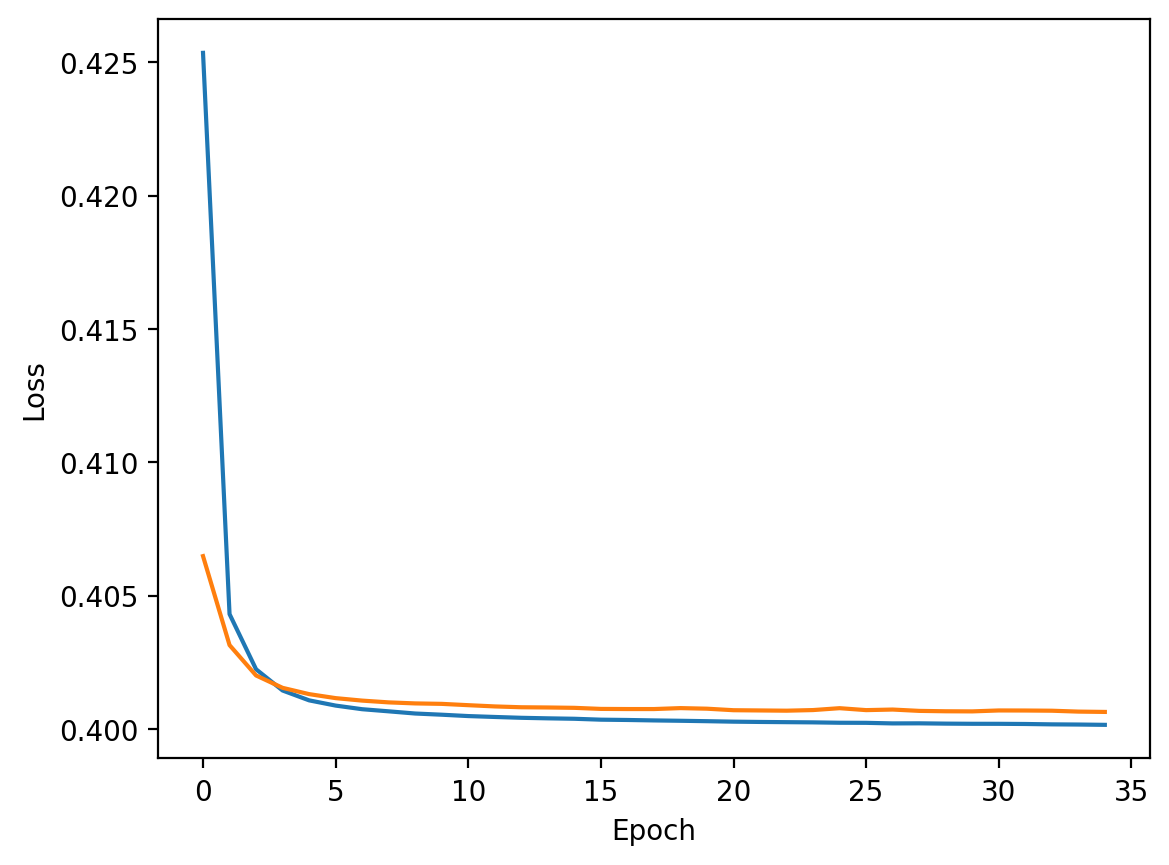

In [16]:
# TF Hub repository (https://tfhub.dev)

import tensorflow_hub as hub

model = tf.keras.Sequential(
    [
        hub.KerasLayer(
            "https://tfhub.dev/google/tf2-preview/nnlm-es-dim50/1",
            output_shape=[50],
            input_shape=[],
            dtype=tf.string,
        ),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(5, activation="sigmoid"),
    ]
)

model.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])

history = model.fit(hub_train_x, train_y, epochs=35, validation_data=(hub_test_x, test_y))

hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail()

# plot history
plt.plot(history.history["loss"], label="Train Error")
plt.plot(history.history["val_loss"], label="Validation Error")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

model.save("saved_model/hub_model.h5")

Epoch 1/5
5270/5270 [==============================] - 654s 123ms/step - loss: 0.4127 - accuracy: 0.1998 - val_loss: 0.4011 - val_accuracy: 0.2005
Epoch 2/5
5270/5270 [==============================] - 566s 107ms/step - loss: 0.4005 - accuracy: 0.2037 - val_loss: 0.4008 - val_accuracy: 0.2007
Epoch 3/5
5270/5270 [==============================] - 601s 114ms/step - loss: 0.4002 - accuracy: 0.2070 - val_loss: 0.4003 - val_accuracy: 0.2155
Epoch 4/5
5270/5270 [==============================] - 709s 134ms/step - loss: 0.3999 - accuracy: 0.2153 - val_loss: 0.4000 - val_accuracy: 0.2246
Epoch 5/5
5270/5270 [==============================] - 684s 130ms/step - loss: 0.3994 - accuracy: 0.2239 - val_loss: 0.3994 - val_accuracy: 0.2257


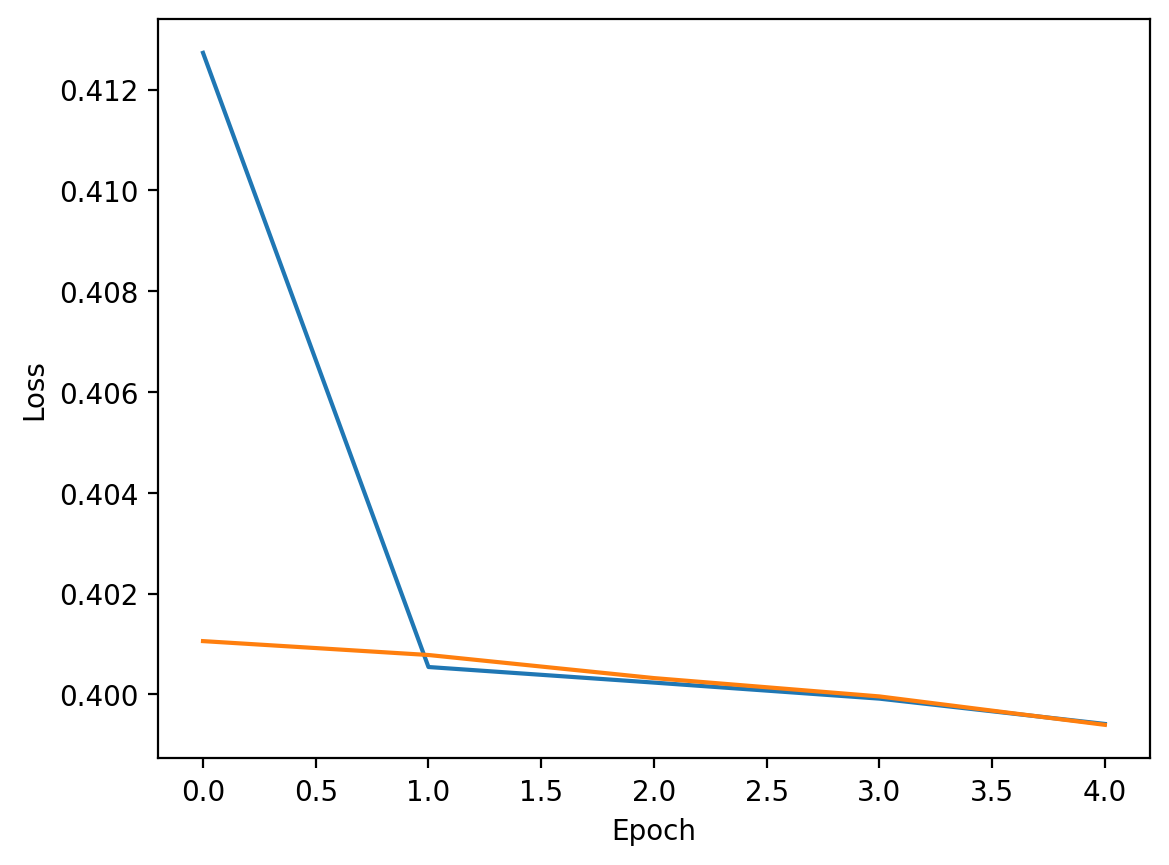

In [17]:
# at last we create the model and train it

model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Embedding(
            vocab_size, embed_size, input_shape=[None], input_length=max_length
        ),
        tf.keras.layers.GRU(128, return_sequences=True),
        tf.keras.layers.GRU(128),
        tf.keras.layers.Dense(5, activation="sigmoid"),
    ]
)

model.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])

history = model.fit(padded, train_y, epochs=5, validation_data=(testing_padded, test_y))

hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail()

# plot history
plt.plot(history.history["loss"], label="Train Error")
plt.plot(history.history["val_loss"], label="Validation Error")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

model.save("saved_model/my_model.h5")